# Structure from motion

## Methods

SFM was performed, which involved collecting feature data using Open cv's SIFT feature detector for randomly selected frames from a video. Then, two-view reconstruciton was performed along with optimization of the calculated pose to reduce the projection error. Then, resectioning was performed in order to add more features from other frames to the list of matched features where the final pose estimates in this step were also optimzed to keep the propigation of pixel errors as low as possible as resectioning was performed repeatedly. 

RANSAC was added to both the two view reconstruction and resectioning. In the two view construction case, eight points were sampled and the essential matrix which was calculated using the sample points which gave the most epipolar distances below a chosen threshold over a chosen number of recalculations is chosen. In the resectioning case, six points are selected and the largest number of reprojection errors below a chosen threshold are chosen. The reprojection error is the difference between the points in the frame that is being resection and the estimated points using the pose estimate that is created during resectioning.

## Results

The 'matching_threshold' was increased to 0.6 because at 0.5 not enough points were being generated where the number of inlers for resectioning would 'run out' in 5 additions of frames from the video; however if using 0.6 as the trehshold, it was possible to perform at least 7 cycles. The reason why I say 'at least' is becasue after that, each addition of a new image would take about 30 minutes to complete and that did not feel like a good use of time.

The number of iterations in the RANSAC implementation for resectioning needed to be increased because the pixel errors for the added image would be too spread out and this was true for a range of different images; this was also tested over many iterations that used different seeds. After increasing the number of iterations, the pixel error was reduced more consistantly over a range testing cycles with different seeds.

'results.rrd', contains the point cloud data over seven images and can be viewed by opening the file in Rerun.io.

## Future Work

I would like to test this code with a different camera which I know I will have to do for the project.

I want to see if I can use the optomizer in C++ because the optimization steps take a very long time; however I do not know how to code in C++ so no better time to learn than the present.

Import everything *except* our sfm library.

In [1]:
# Import symforce for the sole purpose of setting the value
# of epsilon, which must be done first and exactly once.
import symforce
symforce.set_epsilon_to_symbol()

import importlib
from pathlib import Path
import numpy as np
import secrets
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import rerun as rr
from uuid import uuid4

Import our sfm library. (Re-evaluate this cell if you make changes to the library.)

In [2]:
import sfm
importlib.reload(sfm)

<module 'sfm' from '/home/amirn/Documents/UIUC_SP_24/AE_598/ae598-3dv/homework/Project/sfm.py'>

Choose parameter values.

In [3]:
# When reading video frames
frames_to_skip = 30

# When matching (max threshold for ratio test)
matching_threshold = 0.6

# When deciding if triangulated points are invalid
max_reprojection_err = 0.75

fx = 1641.230773199689
fy = 1641.597139080483
cx = 530.846475337206
cy = 973.6379239646022

# Camera matrix
K = np.array([
    [fx, 0.0,cx],
    [0.0, fy, cy],
    [0.0, 0.0, 1.0],
])

Create random number generator.

In [4]:
seed = secrets.randbits(32)
print(f'seeding RNG with {seed}')
rng = np.random.default_rng(seed)

seeding RNG with 574728658


Initialize 3D visualizer (should open the rerun application if that isn't already open).

In [5]:
# Create recording with unique ID
rr.init('my_sfm', recording_id=uuid4(), spawn=True)

# Initialize a time sequence
rr.set_time_seconds('stable_time', 0)

# Make view coordinates consistent with camera frames (z forward, x right, y down)
rr.log('/results', rr.ViewCoordinates.RDF, timeless=True)

[2024-04-28T03:42:20Z INFO  egui_wgpu] There were 2 available wgpu adapters: {backend: Vulkan, device_type: IntegratedGpu, name: "AMD Radeon Vega 3 Graphics (RADV RAVEN)", driver: "radv", driver_info: "Mesa 23.0.4-0ubuntu1~22.04.1", vendor: 0x1002, device: 0x15D8}, {backend: Vulkan, device_type: Cpu, name: "llvmpipe (LLVM 15.0.7, 256 bits)", driver: "llvmpipe", driver_info: "Mesa 23.0.4-0ubuntu1~22.04.1 (LLVM 15.0.7)", vendor: 0x10005}
[2024-04-28T03:42:20Z INFO  tracing::span] perform;
[2024-04-28T03:42:20Z INFO  zbus::handshake] write_command; command=Auth(Some(External), Some([49, 48, 48, 48]))
[2024-04-28T03:42:20Z INFO  tracing::span] read_command;
[2024-04-28T03:42:20Z INFO  zbus::handshake] write_command; command=NegotiateUnixFD
[2024-04-28T03:42:20Z INFO  tracing::span] read_command;
[2024-04-28T03:42:20Z INFO  zbus::handshake] write_command; command=Begin
[2024-04-28T03:42:20Z INFO  tracing::span] socket reader;
[2024-04-28T03:42:20Z INFO  tracing::span] perform;
[2024-04-28T0

Load images from video.

In [6]:
# Specify filename
video_filename = Path('chair.mp4')

# Create a video reader
video_src = cv2.VideoCapture(str(video_filename))

# Get frame count and frames per second
frame_count = int(video_src.get(cv2.CAP_PROP_FRAME_COUNT))
frames_per_second = video_src.get(cv2.CAP_PROP_FPS)

# Read frames
views = []
for i_frame in range(0, frame_count, frames_to_skip):
    video_src.set(cv2.CAP_PROP_POS_FRAMES, i_frame)
    success, frame = video_src.read()
    assert(success)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # img = edgy_image(img)
    views.append({
        'frame_id': i_frame,
        'img': img,
        'R_inB_ofA': None,
        'p_inB_ofA': None,
    })
print(f'read {len(views)} images from video')

[2024-04-28T03:42:20Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:42:20Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Text


[2024-04-28T03:42:20Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Text
[2024-04-28T03:42:20Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default


read 8 images from video


Detection.

In [7]:
# Create a SIFT feature detector
sift = cv2.SIFT_create()

# Apply detector to find keypoints (pts) and descriptors (desc) in each image
for view in views:
    pts, desc = sift.detectAndCompute(image=view['img'], mask=None)
    view['pts'] = [
        {
            'pt2d': np.array(pt.pt),
            'track': None,
        }
        for pt in pts
    ]
    view['desc'] = desc

[2024-04-28T03:42:22Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default


## Initialize with two-view reconstruction

### Get initial guess

Apply matcher.

In [8]:
matches = sfm.get_good_matches(views[0]['desc'], views[1]['desc'], threshold=matching_threshold)
print(f'found {len(matches)} good matches')

found 2280 good matches


Store results.

In [9]:
tracks = []
for match in matches:
    track = {
        'p_inA': None,
        'valid': True,
        'matches': [
            {'view_id': 0, 'feature_id': match.queryIdx},
            {'view_id': 1, 'feature_id': match.trainIdx},
        ]
    }
    tracks.append(track)
    views[0]['pts'][match.queryIdx]['track'] = track
    views[1]['pts'][match.trainIdx]['track'] = track

In [10]:
tracks[0].keys()
tracks[0]['matches']

[{'view_id': 0, 'feature_id': 24865}, {'view_id': 1, 'feature_id': 20480}]

Get image coordinates of matches.

In [11]:
# Create a, b
a = []
b = []
for m in matches:
    a.append(views[0]['pts'][m.queryIdx]['pt2d'])
    b.append(views[1]['pts'][m.trainIdx]['pt2d'])
a = np.array(a)
b = np.array(b)

Visualize all good matches.

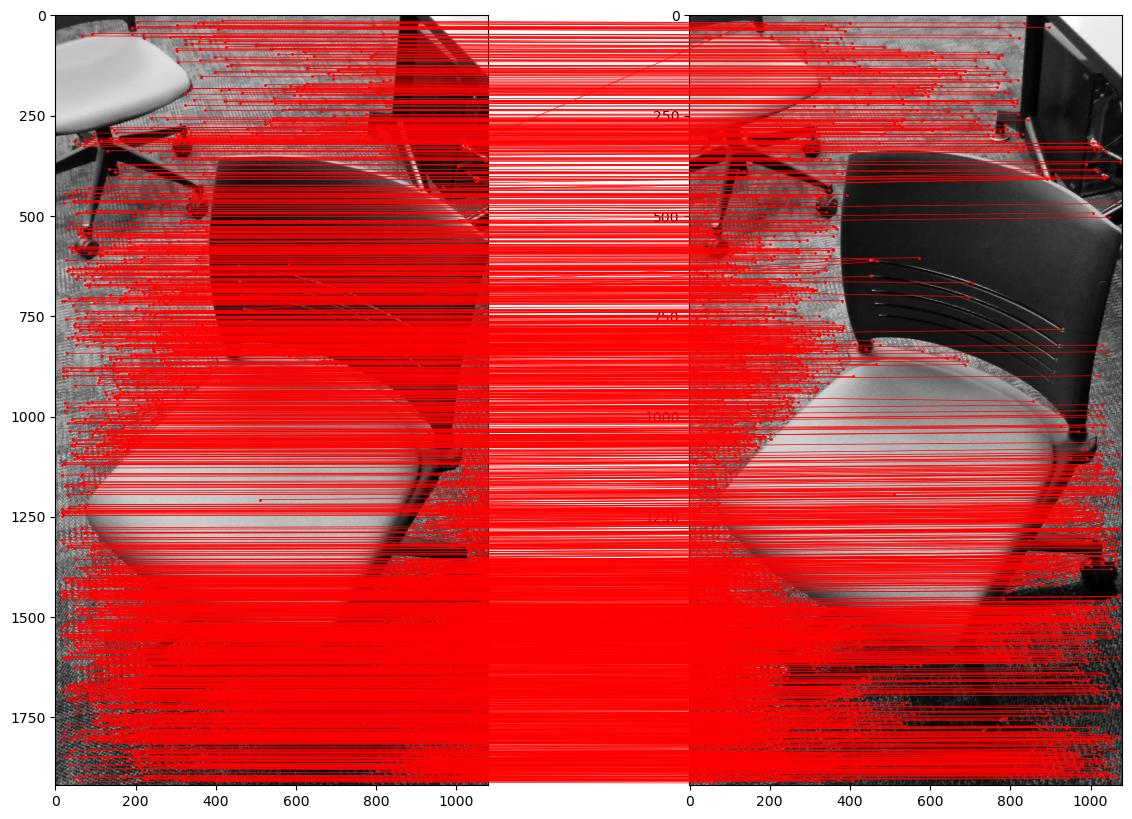

In [12]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Show images
ax1.imshow(views[0]['img'], cmap='gray')
ax2.imshow(views[1]['img'], cmap='gray')

# Show matches
for a_i, b_i in zip(a, b):
    fig.add_artist(
        ConnectionPatch(
            a_i, b_i, 
            'data', 'data',
            axesA=ax1, axesB=ax2,\
            color='red',
            connectionstyle='arc3, rad=0.',
            linewidth=0.5,
        )
    )
    # - Draw red dot at each keypoint
    ax1.plot(a_i[0], a_i[1], 'r.', markersize=2)
    ax2.plot(b_i[0], b_i[1], 'r.', markersize=2)

plt.show()

Do reconstruction.

In [13]:
# Estimate essential matrix
E, num_inliers, mask = sfm.getE(a, b, K, rng, threshold=2e-3, num_iters=1000)
print(f'found {num_inliers} inliers')

# Decompose essential matrix to estimate pose and to triangulate points
R_inB_ofA, p_inB_ofA, p_inA = sfm.decomposeE(a, b, K, E)


found 2264 inliers


Store results.

In [14]:
# Store pose estimates
views[0]['R_inB_ofA'] = np.eye(3)
views[0]['p_inB_ofA'] = np.zeros(3)
views[1]['R_inB_ofA'] = R_inB_ofA
views[1]['p_inB_ofA'] = p_inB_ofA

# Always make sure zipped lists are the same length
assert(len(tracks) == len(p_inA))

# Store the position of the point corresponding to each track
for track, p_inA_i in zip(tracks, p_inA):
    track['p_inA'] = p_inA_i

Show results

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.9999    -0.0123     0.0026    -0.0167]
                             [    0.0123     0.9999     0.0003     0.4846]
                             [   -0.0026    -0.0002     1.0000     0.8746]]

REPROJECTION ERRORS
 Image  0 ( 2280 points) : (mean, std, max, min) = (  2.43,  52.57, 2030.49,   0.00)
 Image  1 ( 2280 points) : (mean, std, max, min) = ( 43.12, 1993.29, 95191.33,   0.00)


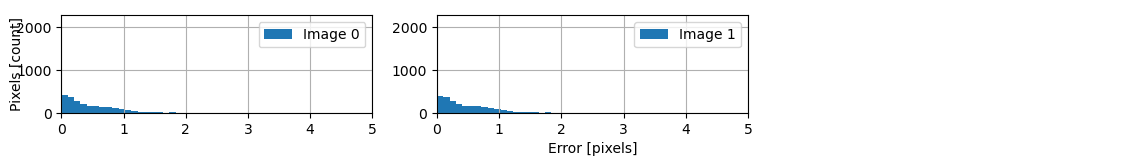

In [15]:
sfm.show_results(views, tracks, K)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_1_ini, tracks_1_ini)
```

In [16]:
views_1_ini, tracks_1_ini = sfm.copy_results(views, tracks)

### Optimize

Create initial values, factors, and optimized keys.

In [17]:
optimizer, initial_values = sfm.get_optimizer(views, tracks, K)

Iterate over 8 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 2280 tracks:
 track 0:
  track_0_p_inA has an initial value and is an optimized key
  track_0_b_0 has an initial value and an sf_projection_residual factor
  track_0_b_1 has an initial value and an sf_projection_residual factor

 ...

 track 2279:
  track_2279_p_inA has an initial value and is an optimized key
  track_2279_b_0 has an initial value and an sf_projection_residual factor
  track_2279_b_1 has an initial value and an sf_projection_residual factor


Create and run optimizer.

In [18]:
result = optimizer.optimize(initial_values)
assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

[2024-04-27 22:44:50.952] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1285.649/0.000/1191.175, rel reduction: 0.07348
[2024-04-27 22:44:59.038] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 1191.175/0.000/1079.851, rel reduction: 0.09346
[2024-04-27 22:45:06.395] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 1079.851/0.000/1038.860, rel reduction: 0.03796
[2024-04-27 22:45:14.232] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 1038.860/0.000/1028.784, rel reduction: 0.00970
[2024-04-27 22:45:23.836] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 1028.784/0.000/1020.166, rel reduction: 0.00838
[2024-04-27 22:45:35.434] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 1020.166/0.000/990.542, rel reduction: 0.02904
[2024-04-27 22:45:43.318] [info] LM<sym::Optimize> [iter    6] lambda: 1.000e-06, e

[2024-04-28T03:46:43Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:46:44Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:46:44Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:46:44Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:46:44Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Text
[2024-04-28T03:46:44Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Text
[2024-04-28T03:46:44Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:46:44Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default


KeyboardInterrupt: 

Store results from optimization (note that this modifies `views` and `tracks` in place).

In [ ]:
sfm.store_results(views, tracks, K, result, max_reprojection_err=max_reprojection_err)

     2 views with updated pose estimate
   134 valid tracks with updated position estimate
     0 already invalid tracks
   342 newly invalid tracks


Show results.

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.9999    -0.0073    -0.0089     0.0384]
                             [    0.0081     0.9951     0.0990    -0.0288]
                             [    0.0082    -0.0991     0.9950     0.9986]]

REPROJECTION ERRORS
 Image  0 (  134 points) : (mean, std, max, min) = (  0.34,   0.21,   0.74,   0.01)
 Image  1 (  134 points) : (mean, std, max, min) = (  0.33,   0.20,   0.72,   0.01)


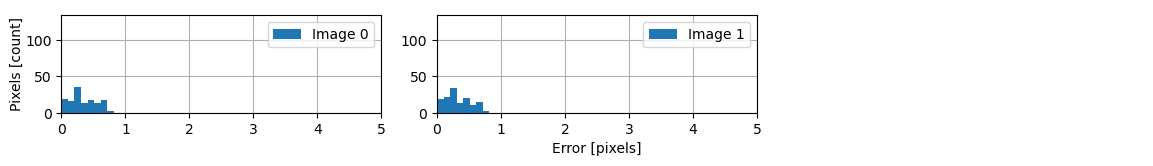

In [ ]:
sfm.show_results(views, tracks, K)

Add visualization of results to the 3D viewer.

In [ ]:
sfm.visualize_results(views, tracks, K, frames_per_second)

[2024-04-28T03:31:34Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:31:34Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Text
[2024-04-28T03:31:34Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Text
[2024-04-28T03:31:34Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default


Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_1_opt, tracks_1_opt)
```

In [ ]:
views_1_opt, tracks_1_opt = sfm.copy_results(views, tracks)

## Add a third image

In [ ]:
# # helps avoid re-running the 1st part of this notebook, can also be used to test individual parts of the code
# import sfm
# importlib.reload(sfm)

# views, tracks = sfm.copy_results(views_1_opt, tracks_1_opt)

### Get initial guess

Match new images with old images, updating views and tracks.

In [ ]:
iC = sfm.add_next_view(views, tracks, K, matching_threshold=matching_threshold)

ADDING VIEW 2

matching image 0 with image 2 with threshold 0.9:
  380 good matches found
  236 tracks created
    0 tracks in C extended with point in B
  144 tracks in B extended with point in C
    0 tracks merged (trivial)
    0 tracks merged (non-trivial)
    0 inconsistent tracks

matching image 1 with image 2 with threshold 0.9:
  331 good matches found
       trivial merge - ( 1,  243) ( 2,  623) - ( 0,  538) ( 1,  243) ( 2,  623) 
       trivial merge - ( 1,  214) ( 2,  616) - ( 0,  498) ( 1,  214) ( 2,  616) 
       trivial merge - ( 1, 1248) ( 2, 1869) - ( 0, 2321) ( 1, 1248) ( 2, 1869) 
       trivial merge - ( 1, 1263) ( 2, 1921) - ( 0, 2367) ( 1, 1263) ( 2, 1921) 
       trivial merge - ( 1,   93) ( 2,  454) - ( 0,  200) ( 1,   93) ( 2,  454) 
       trivial merge - ( 1,  106) ( 2,  519) - ( 0,  284) ( 1,  106) ( 2,  519) 
       trivial merge - ( 1,  236) ( 2,  631) - ( 0,  531) ( 1,  236) ( 2,  631) 
       trivial merge - ( 1,  277) ( 2,  695) - ( 0,  603) ( 1,  277) (

Get data for resectioning. Look for tracks that...
* are valid
* have a match with `view_id` that is the same as the new view
* have `p_inA` that is not `None`

Also get data for triangulation. Look for tracks that...
* are valid
* have a match with `view_id` that is the same as the new view
* have `p_inA` that is `None`

In [ ]:
tracks_to_resection = []
tracks_to_triangulate = []
for track in tracks:
    if not track['valid']:
        continue
    
    match = sfm.get_match_with_view_id(track['matches'], iC)
    if match is None:
        continue

    if track['p_inA'] is None:
        tracks_to_triangulate.append(track)
    else:
        tracks_to_resection.append(track)

print(f'{len(tracks_to_resection)} tracks to resection')
print(f'{len(tracks_to_triangulate)} tracks to triangulate')

68 tracks to resection
359 tracks to triangulate


#### Resection

The output of this process is an estimate of the pose $R^C_A, p^C_A$.

In [ ]:
p_inA = []
c = []
for track in tracks_to_resection:
    assert(track['p_inA'] is not None)
    p_inA.append(track['p_inA'])
    match = sfm.get_match_with_view_id(track['matches'], iC)
    c.append(sfm.get_pt2d_from_match(views, match))
p_inA = np.array(p_inA)
c = np.array(c)

print(f'len(p_inA) = {len(p_inA)}, len(c) = {len(c)}')

len(p_inA) = 68, len(c) = 68


Visualize the image coordinates of points on which PnP will be based.

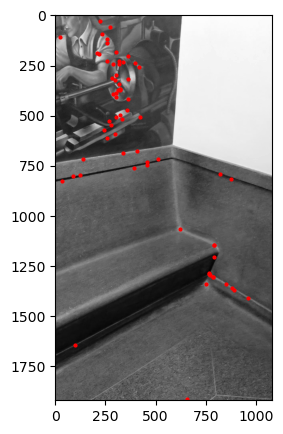

In [ ]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Show image
ax.imshow(views[iC]['img'], cmap='gray')

# Show matches corresponding to points that have already been triangulated
ax.plot(c[:, 0], c[:, 1], 'r.', markersize=4)

# Show plot    
plt.show()

Solve a PnP problem to estimate relative pose.

In [ ]:
R_inC_ofA, p_inC_ofA, num_inliers, mask = sfm.resection(
    p_inA,
    c,
    K,
    rng,
    threshold=1.5,
    num_iters=8000,
)
print(f'found {num_inliers} inliers out of {len(mask)}')

[2024-04-28T03:31:36Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:31:37Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:31:37Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:31:37Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Text
[2024-04-28T03:31:37Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Text
[2024-04-28T03:31:37Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default


found 1 inliers out of 68


Store results.

In [ ]:
views[iC]['R_inB_ofA'] = R_inC_ofA
views[iC]['p_inB_ofA'] = p_inC_ofA

#### Triangulate

Apply function to triangulate all new tracks. Store results.

In [ ]:
for track in tracks_to_triangulate:
    p_inA = sfm.triangulate(track, views, K)
    track['p_inA'] = p_inA

#### Show results

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.9999    -0.0073    -0.0089     0.0384]
                             [    0.0081     0.9951     0.0990    -0.0288]
                             [    0.0082    -0.0991     0.9950     0.9986]]
 [R_inA_ofB2, p_inA_ofB2] = [[    0.9952     0.0328    -0.0925    -0.5448]
                             [   -0.0180     0.9875     0.1566    -0.3264]
                             [    0.0964    -0.1542     0.9833     2.8163]]



REPROJECTION ERRORS
 Image  0 (  345 points) : (mean, std, max, min) = (639.14, 5913.97, 103916.73,   0.01)
 Image  1 (  287 points) : (mean, std, max, min) = (274.48, 955.99, 11261.14,   0.01)
 Image  2 (  427 points) : (mean, std, max, min) = (812.84, 6021.76, 97516.32,   0.02)


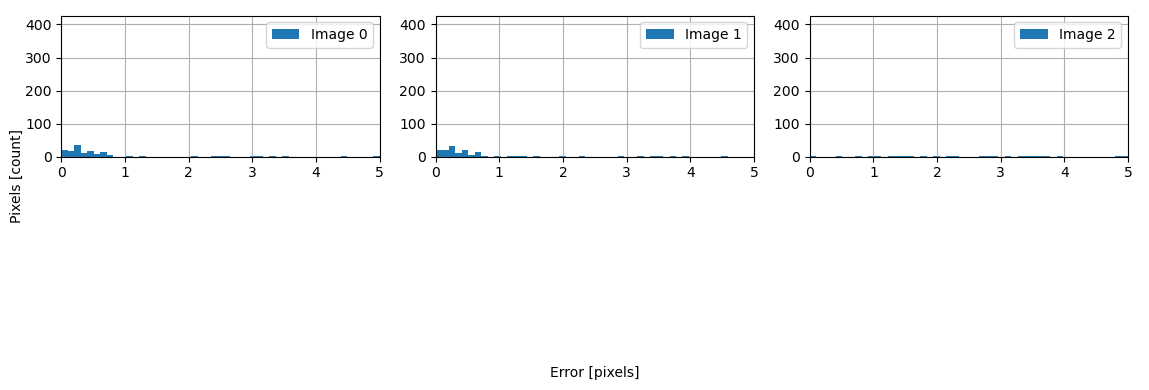

In [ ]:
sfm.show_results(views, tracks, K)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_2_ini, tracks_2_ini)
```

In [ ]:
views_2_ini, tracks_2_ini = sfm.copy_results(views, tracks)

### Optimize

Create initial values, factors, and optimized keys.

In [ ]:
optimizer, initial_values = sfm.get_optimizer(views, tracks, K)

Iterate over 9 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
 T_inB2_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 831 tracks:
 track 0:
  track_0_p_inA has an initial value and is an optimized key
  track_0_b_0 has an initial value and an sf_projection_residual factor
  track_0_b_1 has an initial value and an sf_projection_residual factor

 ...

 track 830:
  track_830_p_inA has an initial value and is an optimized key
  track_830_b_1 has an initial value and an sf_projection_residual factor
  track_830_b_2 has an initial value and an sf_projection_residual factor


Create and run optimizer.

In [ ]:
result = optimizer.optimize(initial_values)
assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

[2024-04-28T03:31:50Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:31:51Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default


[2024-04-27 22:31:51.646] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 1570.163/0.000/1565.415, rel reduction: 0.00302
[2024-04-27 22:31:52.014] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 1565.415/0.000/1546.792, rel reduction: 0.01190
[2024-04-27 22:31:52.346] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 1546.792/0.000/1533.889, rel reduction: 0.00834
[2024-04-27 22:31:52.698] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 1533.889/0.000/1528.945, rel reduction: 0.00322
[2024-04-27 22:31:53.033] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 1528.945/0.000/1525.941, rel reduction: 0.00197
[2024-04-27 22:31:53.369] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 1525.941/0.000/1522.752, rel reduction: 0.00209
[2024-04-27 22:31:53.667] [info] LM<sym::Optimize> [iter    6] lambda: 1.000e-06, 

[2024-04-28T03:31:54Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default


[2024-04-27 22:31:54.448] [info] LM<sym::Optimize> [iter    8] lambda: 1.000e-08, error prev/linear/new: 1516.605/0.000/1514.262, rel reduction: 0.00154
[2024-04-27 22:31:54.822] [info] LM<sym::Optimize> [iter    9] lambda: 1.000e-09, error prev/linear/new: 1514.262/0.000/1512.131, rel reduction: 0.00141
[2024-04-27 22:31:55.141] [info] LM<sym::Optimize> [iter   10] lambda: 1.000e-10, error prev/linear/new: 1512.131/0.000/1507.011, rel reduction: 0.00339


[2024-04-28T03:31:55Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:31:55Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:31:55Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:31:55Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Text
[2024-04-28T03:31:55Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Text
[2024-04-28T03:31:55Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default


[2024-04-27 22:31:55.597] [info] LM<sym::Optimize> [iter   11] lambda: 1.000e-11, error prev/linear/new: 1507.011/0.000/1505.151, rel reduction: 0.00123
[2024-04-27 22:31:55.939] [info] LM<sym::Optimize> [iter   12] lambda: 1.000e-12, error prev/linear/new: 1505.151/0.000/1503.168, rel reduction: 0.00132


[2024-04-28T03:31:56Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default


[2024-04-27 22:31:56.321] [info] LM<sym::Optimize> [iter   13] lambda: 1.000e-13, error prev/linear/new: 1503.168/0.000/1501.356, rel reduction: 0.00121
[2024-04-27 22:31:56.644] [info] LM<sym::Optimize> [iter   14] lambda: 1.000e-14, error prev/linear/new: 1501.356/0.000/1500.341, rel reduction: 0.00068
[2024-04-27 22:31:56.644] [warning] LM<sym::Optimize> Zero on diagonal at indices: [1321, 1322]
[2024-04-27 22:31:57.049] [info] LM<sym::Optimize> [iter   15] lambda: 1.000e-15, error prev/linear/new: 1500.341/0.000/1503.317, rel reduction: -0.00198
[2024-04-27 22:31:57.467] [info] LM<sym::Optimize> [iter   16] lambda: 5.000e-15, error prev/linear/new: 1500.341/0.000/1503.305, rel reduction: -0.00198
[2024-04-27 22:31:57.875] [info] LM<sym::Optimize> [iter   17] lambda: 2.500e-14, error prev/linear/new: 1500.341/0.000/1502.201, rel reduction: -0.00124
[2024-04-27 22:31:58.226] [info] LM<sym::Optimize> [iter   18] lambda: 1.250e-13, error prev/linear/new: 1500.341/0.000/1499.874, rel re

Store results from optimization (note that this modifies `views` and `tracks` in place).

In [ ]:
sfm.store_results(views, tracks, K, result, max_reprojection_err=max_reprojection_err)

     3 views with updated pose estimate
    69 valid tracks with updated position estimate
   350 already invalid tracks
   412 newly invalid tracks


Show results.

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.9999    -0.0075    -0.0089     0.0380]
                             [    0.0084     0.9950     0.0992    -0.0281]
                             [    0.0081    -0.0993     0.9950     0.9984]]
 [R_inA_ofB2, p_inA_ofB2] = [[    0.9945     0.0304    -0.1000    -0.3590]
                             [   -0.0149     0.9882     0.1522    -0.1569]
                             [    0.1034    -0.1499     0.9833     2.4784]]

REPROJECTION ERRORS
 Image  0 (   56 points) : (mean, std, max, min) = (  0.31,   0.21,   0.73,   0.01)
 Image  1 (   65 points) : (mean, std, max, min) = (  0.32,   0.21,   0.71,   0.00)
 Image  2 (   17 points) : (mean, std, max, min) = (  0.40,   0.21,   0.66,   0.06)


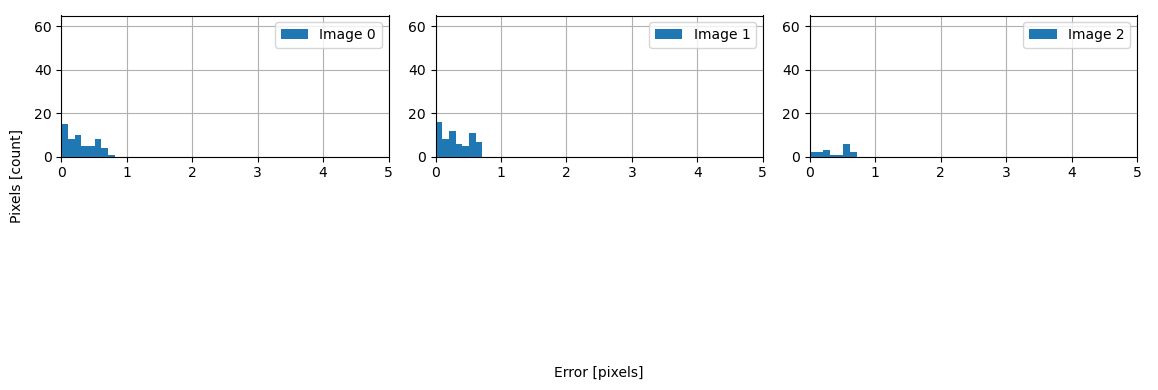

In [ ]:
sfm.show_results(views, tracks, K)

Add visualization of results to the 3D viewer.

In [ ]:
# fig, ax = plt.subplots(1, 1)
# ax.hist(initial_errors, alpha=0.5, label='before optimization')
# ax.hist(final_errors, alpha=0.5, label='after optimization')
# ax.legend()
# ax.set_xlabel('Error [pixels]')
# ax.set_ylabel('Pixel Count')
# plt.show()
views[0]

{'frame_id': 0,
 'img': array([[ 66,  58,  53, ..., 218, 218, 218],
        [ 75,  67,  57, ..., 218, 218, 218],
        [ 56,  67,  74, ..., 218, 218, 218],
        ...,
        [ 15,  14,  12, ...,  65,  69,  64],
        [ 12,  12,  11, ...,  74,  74,  69],
        [  6,   6,   7, ...,  71,  64,  63]], dtype=uint8),
 'R_inB_ofA': array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 'p_inB_ofA': array([0., 0., 0.]),
 'pts': [{'pt2d': array([   2.37935376, 1023.84893799]),
   'track': {'p_inA': array([ 1.7362835 , -0.36141619, -5.27214819]),
    'valid': False,
    'matches': [{'view_id': 0, 'feature_id': 0},
     {'view_id': 2, 'feature_id': 362}]}},
  {'pt2d': array([   2.77779531, 1638.22949219]), 'track': None},
  {'pt2d': array([   2.77779531, 1638.22949219]), 'track': None},
  {'pt2d': array([   3.68949676, 1641.80981445]), 'track': None},
  {'pt2d': array([  4.10964108, 334.62106323]), 'track': None},
  {'pt2d': array([  4.54740953, 229.87742615]),
   'track': {'

In [ ]:
sfm.visualize_results(views, tracks, K, frames_per_second)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_2_opt, tracks_2_opt)
```

In [ ]:
views_2_opt, tracks_2_opt = sfm.copy_results(views, tracks)

## All Resectioning Steps w/out Plots

In [ ]:
iC = sfm.add_next_view(views, tracks, K, matching_threshold=matching_threshold)
tracks_to_resection = []
tracks_to_triangulate = []
for track in tracks:
    if not track['valid']:
        continue
    
    match = sfm.get_match_with_view_id(track['matches'], iC)
    if match is None:
        continue

    if track['p_inA'] is None:
        tracks_to_triangulate.append(track)
    else:
        tracks_to_resection.append(track)

print(f'{len(tracks_to_resection)} tracks to resection')
print(f'{len(tracks_to_triangulate)} tracks to triangulate')
p_inA = []
c = []
for track in tracks_to_resection:
    assert(track['p_inA'] is not None)
    p_inA.append(track['p_inA'])
    match = sfm.get_match_with_view_id(track['matches'], iC)
    c.append(sfm.get_pt2d_from_match(views, match))
p_inA = np.array(p_inA)
c = np.array(c)

print(f'len(p_inA) = {len(p_inA)}, len(c) = {len(c)}')
R_inC_ofA, p_inC_ofA, num_inliers, mask = sfm.resection(
    p_inA,
    c,
    K,
    rng,
    threshold=1.5,
    num_iters=8000,
)
print(f'found {num_inliers} inliers out of {len(mask)}')
views[iC]['R_inB_ofA'] = R_inC_ofA
views[iC]['p_inB_ofA'] = p_inC_ofA
for track in tracks_to_triangulate:
    p_inA = sfm.triangulate(track, views, K)
    track['p_inA'] = p_inA
views_2_ini, tracks_2_ini = sfm.copy_results(views, tracks)

optimizer, initial_values = sfm.get_optimizer(views, tracks, K)

result = optimizer.optimize(initial_values)
assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

sfm.store_results(views, tracks, K, result, max_reprojection_err=max_reprojection_err)

sfm.visualize_results(views, tracks, K, frames_per_second)

views_2_opt, tracks_2_opt = sfm.copy_results(views, tracks)

ADDING VIEW 3


[2024-04-28T03:32:04Z WARN  re_sdk_comms::buffered_client] Failed to send message after 3 attempts: Failed to send to Rerun server at 127.0.0.1:9876: Broken pipe (os error 32)



matching image 0 with image 3 with threshold 0.9:
  450 good matches found
       FOUND INCONSISTENT - ( 0,  823) ( 1,  358) ( 2,  444) ( 2,  890) ( 1,   89) ( 3, 1922) 
       FOUND INCONSISTENT - ( 0,   34) ( 1,   10) ( 2,  523) ( 1,   96) ( 3,  890) 
       FOUND INCONSISTENT - ( 0, 1588) ( 2,   36) ( 0, 1546) ( 1,  710) ( 3, 1527) 
       FOUND INCONSISTENT - ( 0, 1490) ( 1,  694) ( 2, 1382) ( 2, 1383) ( 3, 3161) 
       FOUND INCONSISTENT - ( 0, 1563) ( 1,  845) ( 2, 1447) ( 2, 1558) ( 3, 3280) 
       FOUND INCONSISTENT - ( 0,  461) ( 1,  213) ( 2, 2055) ( 1, 1362) ( 3, 1368) 
       FOUND INCONSISTENT - ( 0,  268) ( 2,  500) ( 0,  321) ( 1,  132) ( 3, 1204) 
       FOUND INCONSISTENT - ( 0, 1249) ( 1,  562) ( 2, 1236) ( 2, 1249) ( 3, 2749) 
       FOUND INCONSISTENT - ( 0,  822) ( 1, 1195) ( 2,  864) ( 2, 1832) ( 3, 1924) 
       FOUND INCONSISTENT - ( 0, 2346) ( 2, 1914) ( 0, 2399) ( 1, 1193) ( 3, 4868) 
       FOUND INCONSISTENT - ( 0,  849) ( 1,  356) ( 2,  897) ( 2,  172) (

[2024-04-28T03:32:07Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.


found 2 inliers out of 30
Iterate over 9 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
 T_inB2_ofA has an initial value and is an optimized key
 T_inB3_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 1502 tracks:
 track 0:
  track_0_p_inA has an initial value and is an optimized key
  track_0_b_0 has an initial value and an sf_projection_residual factor
  track_0_b_1 has an initial value and an sf_projection_residual factor
  track_0_b_3 has an initial value and an sf_projection_residual factor

 ...

 track 1501:
  track_1501_p_inA has an initial value and is an optimized key
  track_1501_b_2 has an initial value and an sf_projection_residual factor
  track_1501_b_3 has an initial value and an sf_projection_residual factor
[2024-04-27 22:32:19.071] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 2198.490/0.000/2143.283, rel reduction: 0.02511
[2024

KeyboardInterrupt: 

In [ ]:
import sfm
importlib.reload(sfm)
p_inA_temp = np.array([track['p_inA'] for track in tracks if track['valid'] and track['p_inA'] is not None])

P_in = sfm.remove_outliers(p_inA_temp)
a = P_in
a_ = p_inA_temp


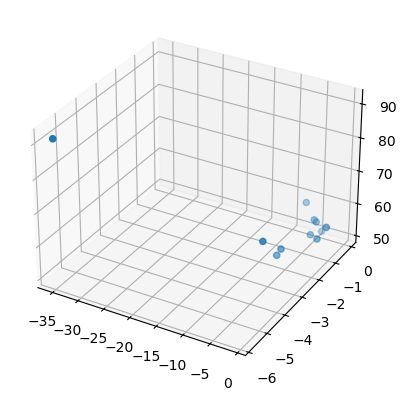

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(a[:,0], a[:,1], a[:,2])
# ax.scatter(a_[:,0], a_[:,1], a_[:,2], s=8)
plt.show()

In [ ]:
sfm.write_csv('P_switch.csv', a_)

[2024-04-28T03:29:01Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:29:01Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:29:01Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to EwResize
[2024-04-28T03:29:01Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to EwResize
[2024-04-28T03:29:01Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
[2024-04-28T03:29:04Z WARN  winit::platform_impl::platform::wayland::window::state] Failed to set cursor to Default
